In [1]:
from __future__ import print_function
DAO_SEXPARAMS = 'default.sex'
DAO_NNW = 'default.nnw'
HOSTPHOT_SEXOUTCOLS = 'sex.default.param'
DAO_KERNEL = 'gauss_4.0_7x7.conv'
import os
import numpy as np
import scipy.optimize as optimize
import sys
from subprocess import check_call
import subprocess
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units

from numpy import *
import scipy.special as special
from matplotlib.pyplot import *
%matplotlib inline
from IPython.display import Image

%matplotlib inline

In [2]:
def getHostMatchfromSex(imfile,eventra,eventdec, r_ap, s=1.3, maxRparam=6,ext=0,returnShapePars=False, plott=False, graph=False):
    print('running SExtractor:')
    
    subprocess.run(["sex "+file_fits+" -FILTER_NAME gauss_4.0_7x7.conv  -DETECT_THRESH 2.0  -GAIN 1.0  -DEBLEND_MINCONT 0.5 -PARAMETERS_NAME sex.default.param -CATALOG_NAME catalog_file.cat"], stdout=subprocess.PIPE, shell=True)

    print('getting host nearest position %s, %s'%(eventra,eventdec))

    hdr = fits.getheader(imfile,ext=ext)
    ImWCS = wcs.WCS(hdr)

    xylist = ImWCS.wcs_world2pix(eventra,eventdec,0)
    snx,sny = xylist
    
    sextable = np.genfromtxt('catalog_file.cat')
    

    C_xx = np.cos(sextable[:,7]*np.pi/180.)**2./sextable[:,14]**2. + \
           np.sin(sextable[:,7]*np.pi/180.)**2./sextable[:,15]**2.
    C_yy = np.sin(sextable[:,7]*np.pi/180.)**2./sextable[:,14]**2. + \
           np.cos(sextable[:,7]*np.pi/180.)**2./sextable[:,15]**2.
    C_xy = 2*np.cos(sextable[:,7]*np.pi/180.)*np.sin(sextable[:,7]*np.pi/180.)*(1./sextable[:,14]**2. + 1/sextable[:,15]**2.)
    x_r = snx - sextable[:,0]
    y_r = sny - sextable[:,1]

    Rpar = np.sqrt(C_xx*x_r**2. + C_yy*y_r**2. + np.abs(C_xy*x_r*y_r))
    
    print ('Rpar Min:', np.min(Rpar))
    if np.min(Rpar) < maxRparam:
        iRpar = np.where(Rpar == np.min(Rpar))[0]
        hostra,hostdec = sextable[:,12][iRpar],sextable[:,13][iRpar]
        if plott==True:
        
            data_i = fits.getdata(imfile)
            f_i = fits.open(imfile)
            header_i = f_i[0].header
            wi = WCS(header_i)

            ra_SN, dec_SN = eventra, eventdec
            xi_SN, yi_SN = wi.all_world2pix(ra_SN, dec_SN, 1)

            u,v = wi.all_world2pix(hostra[0], hostdec[0], 1)
            a=sextable[:,14][iRpar][0]*s     #radius on the x-axis
            b=sextable[:,15][iRpar][0]*s   #radius on the y-axis

            t_rot=sextable[:,7][iRpar][0] * np.pi/180 #rotation angle

            t = np.linspace(0, 2*np.pi, 100)
            Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
            R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  

            Ell_rot = np.zeros((2,Ell.shape[1]))
            for i in range(Ell.shape[1]):
                Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
            if graph == True:

                figure(figsize=(10,10))

                imshow(data_i, cmap='viridis', vmin=100, vmax=500)
                xlim(xi_SN-100, xi_SN+150)
                ylim(yi_SN-100, yi_SN+150)
                gca().add_patch(Circle((xi_SN, yi_SN), r_ap, color='r', fill=False, label='SN'))
                #gca().add_patch(Circle((xi_SN, yi_SN), 4, color='r', fill=False, label='SN'))

                plot( u+Ell_rot[0,:] , v+Ell_rot[1,:], color='magenta', label='isophot' )
                plot(u,v, '*', markersize=30, color='magenta', label='ellipse center')

                legend(loc='upper right', fontsize=25)
        
        if returnShapePars:
            return(hostra,hostdec,np.min(Rpar),a,b,t_rot, xi_SN, yi_SN, u, v)
            #return(hostra,hostdec,np.min(Rpar),sextable[:,14][iRpar],sextable[:,15][iRpar],sextable[:,7][iRpar],sextable[:,2][iRpar])
        else:
            return(hostra,hostdec)
    else:
        if returnShapePars:
            return(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)
        else:
            return(np.nan,np.nan)



running SExtractor:
getting host nearest position 220.0418623, 42.7776247
Rpar Min: 3.352154663095561


/bin/sh: sex: command not found
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


(array([220.03889048]),
 array([42.7792767]),
 3.352154663095561,
 37.777,
 11.742,
 0.4745550236172582,
 array(1250.92776394),
 array(2185.22726895),
 array(1281.7142927),
 array(2209.88386907))

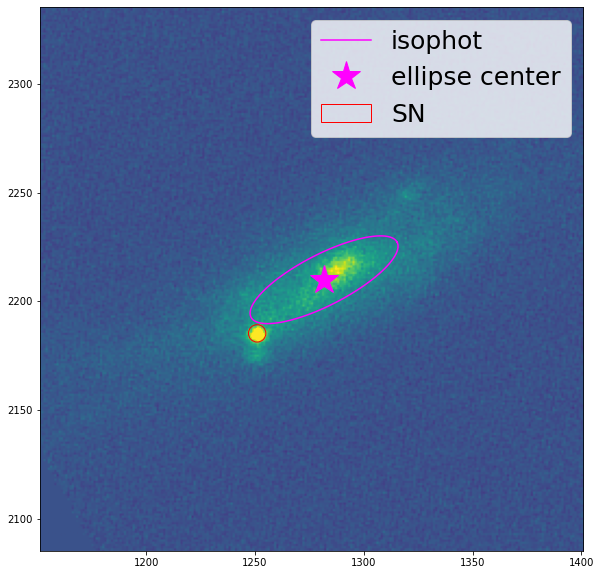

In [3]:
#all inputs are here
file_fits = '2020tlf.g.200912_2281713_2199.069.sw.fits'
ext1=0
imfile = file_fits
ra = 220.0418623
dec = 42.7776247
r_ap = 4 #aperture radius
getHostMatchfromSex(file_fits, ra, dec, ext = ext1, r_ap = 4, s=1, returnShapePars=True, plott=True, graph=True)
#function call was changed for my purposes, will fix it later

running SExtractor:
getting host nearest position 220.0418623, 42.7776247
Rpar Min: 3.352154663095561
r_sn =39.443101838219775
ellipse r at theta_sn = 39.443101838219775


/bin/sh: sex: command not found
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


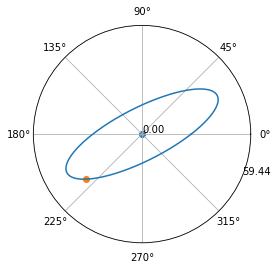

In [5]:
#this is root solving a semi-minor axis that passes through the sn given the eccentricity of the ellipse
from matplotlib import patches
hra, hdec, rpar, a, b, phi, x, y, u, v = getHostMatchfromSex(file_fits, ra, dec, r_ap=4, s=1, returnShapePars=True, plott=True, graph=False)
r_sn = np.sqrt((x-u)**2+(y-v)**2)
theta_sn = np.arctan2(y-v,x-u)
if theta_sn < 0:
    theta_sn = theta_sn+2*np.pi
e = np.sqrt(1-(b/a)**2)
theta_plot = np.linspace(0, 2*np.pi, 1000)

def ell_to_sn(b_opt):
    return r_sn - (b_opt/np.sqrt(1-(e*np.cos(theta_sn-phi))**2))

b_opt=optimize.root_scalar(ell_to_sn, bracket=[0, r_sn], xtol=1e-10).root
a_opt = b_opt/np.sqrt(1-e**2)

def ellipse(theta, phi=0):
    return b_opt/np.sqrt(1-(e*np.cos(theta-phi))**2)

fig, ax = subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_plot, ellipse(theta_plot, phi=phi))
ax.scatter(0, 0)
ax.scatter(theta_sn, r_sn)
ax.set_rmax(2)
ax.set_rticks([0, r_sn+20])
ax.set_rlabel_position(-22.5)  
ax.grid(True)

print('r_sn ='+str(r_sn))
print('ellipse r at theta_sn = ' +str(ellipse(theta_sn, phi)))

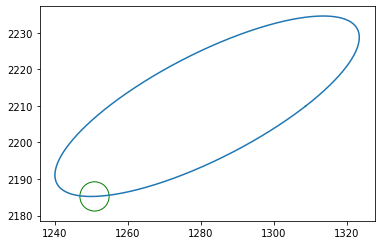

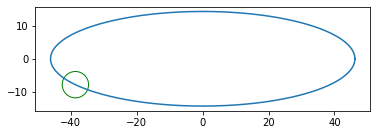

In [6]:
#this checking a rotation of the ellipse and sn location so that the ellipse is aligned with the xy-axes
figure()
x_ell = ellipse(theta_plot, phi)*np.cos(theta_plot)
y_ell = ellipse(theta_plot, phi)*np.sin(theta_plot)
ax = plot(x_ell+u, y_ell+v)
gca().add_patch(Circle((x, y), radius=r_ap, fill=False, color='g'))
axis('scaled')
show()

figure()
theta_i = theta_sn - phi
x_ell_new = ellipse(theta_plot, phi=0)*np.cos(theta_plot)
y_ell_new = ellipse(theta_plot, phi=0)*np.sin(theta_plot)
x_new = ellipse(theta_i)*np.cos(theta_i)
y_new = ellipse(theta_i)*np.sin(theta_i)
ax = plot(x_ell_new, y_ell_new)
gca().add_patch(Circle((x_new, y_new), radius=r_ap, fill=False, color='g'))
axis('scaled')
show()

In [7]:
#first it determines how many apertures can roughly fit if you space the centers equal arc lengths apart
#then it determines the spacing

perimeter = a_opt*special.ellipeinc(2*np.pi, e**2)
n = (perimeter)/(2*r_ap)
num = int(floor(n))
space = ((perimeter-(num*2*r_ap))/num) + 2*r_ap

#it determines the amplitude at the sn location
#it then findsarc length covered from amplitude=0 to the amplitude of the sn location
def xy_amp_diff(amp, a, b, x, y):
    return np.sqrt((a*np.sin(amp)-x)**2 + (b*np.cos(amp)-y)**2)

amp=optimize.root(xy_amp_diff, x0=theta_i, args=(a_opt, b_opt, x_new, y_new), tol=1e-10).x 
arc_sn = a_opt*special.ellipeinc(amp, e**2) 

#it then adds the spacing in increments until it covers the whole ellipse in points
arc_bkg_ap = arc_sn + np.arange(num) * space
angles_0 = 2 * np.pi * np.arange(num) / num

#then it solves for the amplitudes of the apertures given their arc_lengths
amp_bkg_ap = optimize.root(lambda x: (a_opt*special.ellipeinc(x, e**2) - arc_bkg_ap), angles_0, tol=1e-10).x 

#converts them to x and y coordinates
x_bkg_ap = a_opt * np.sin(amp_bkg_ap)
y_bkg_ap = b_opt * np.cos(amp_bkg_ap)

#this section of code checks for overlaps
#if any center is less than 2 radii from another, we reduce num by one and repeat the process above
#this continues until there is no overlap
x_ap_check = np.append(x_bkg_ap, x_bkg_ap[0])
y_ap_check = np.append(y_bkg_ap, y_bkg_ap[0])
d_x = np.diff(x_ap_check)
d_y = np.diff(y_ap_check)

d_ap = np.sqrt(d_x**2+d_y**2)
    
overlap = np.count_nonzero(d_ap<2*r_ap)

while overlap > 0:
    num=num-1
    space = ((perimeter-(num*2*r_ap))/num) + 2*r_ap
    arc_bkg_ap = arc_sn + np.arange(num) * space
    angles_0 = 2 * np.pi * np.arange(num) / num
    amp_bkg_ap = optimize.root(lambda x: (a_opt*special.ellipeinc(x, e**2) - arc_bkg_ap), angles_0, tol=1e-10).x 
    
    x_bkg_ap = a_opt * np.sin(amp_bkg_ap)
    y_bkg_ap = b_opt * np.cos(amp_bkg_ap)

    x_ap_check = np.append(x_bkg_ap, x_bkg_ap[0])
    y_ap_check = np.append(y_bkg_ap, y_bkg_ap[0])
    d_x = np.diff(x_ap_check)
    d_y = np.diff(y_ap_check)
    d_ap = np.sqrt(d_x**2+d_y**2)
    overlap = np.count_nonzero(d_ap<2*r_ap)

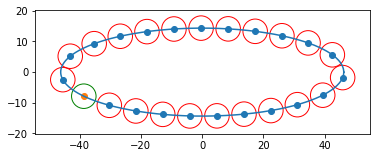

In [8]:
#checking that everything worked before rotating and translating the apertures back onto the image
figure()
x_ell_new = ellipse(theta_plot, phi=0)*np.cos(theta_plot)
y_ell_new = ellipse(theta_plot, phi=0)*np.sin(theta_plot)

x_new = ellipse(theta_i)*np.cos(theta_i)
y_new = ellipse(theta_i)*np.sin(theta_i)

x_bkg_ap_cut = x_bkg_ap[1:]
y_bkg_ap_cut = y_bkg_ap[1:]

ax = plot(x_ell_new, y_ell_new)
scatter(x_bkg_ap_cut, y_bkg_ap_cut)
scatter(x_new, y_new)
gca().add_patch(Circle((x_new, y_new), radius=r_ap, fill=False, color='g'))
for i in range(len(x_bkg_ap_cut)):
    gca().add_patch(Circle((x_bkg_ap_cut[i], y_bkg_ap_cut[i]), radius=r_ap, fill=False, color='r'))
axis('scaled')
show()

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


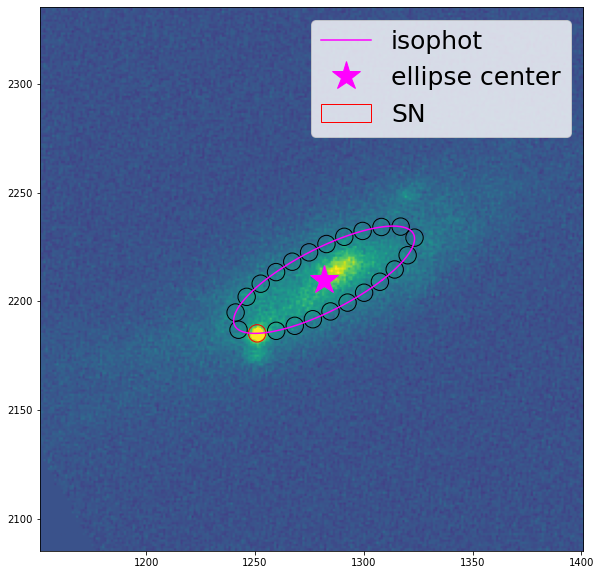

In [9]:
#rotating and translating the apertures back onto the image
x_bkg_final = x_bkg_ap_cut * np.cos(phi) -  y_bkg_ap_cut * np.sin(phi) + u
y_bkg_final = x_bkg_ap_cut * np.sin(phi) +  y_bkg_ap_cut * np.cos(phi) + v

data = fits.getdata(imfile)
f = fits.open(imfile)
header = f[0].header
wi = WCS(header)
figure(figsize=(10,10))

imshow(data, cmap='viridis', vmin=100, vmax=500)
xlim(x-100, x+150)
ylim(y-100, y+150)
gca().add_patch(Circle((x, y), r_ap, color='r', fill=False, label='SN'))

plot( x_ell+u, y_ell+v, color='magenta', label='isophot' )
plot(u,v, '*', markersize=30, color='magenta', label='ellipse center')
for i in range(len(x_bkg_final)):
    gca().add_patch(Circle((x_bkg_final[i], y_bkg_final[i]), radius=r_ap, fill=False, color='black'))

legend(loc='upper right', fontsize=25)


show()

In [10]:
#converting from pixel values to arcseconds
x_r, y_r = wi.all_pix2world(x, y+r_ap, 1)
r_world = np.array([x_r, y_r])-np.array([ra, dec])
r_world_arcsec = abs((r_world*units.deg).to(units.arcsec).value)[1] #radius in arseconds

ra_bkg, dec_bkg = wi.all_pix2world(x_bkg_final, y_bkg_final, 1) #aperture coords in degree ra/dec as seperate arrays
#ra_bkg, dec_bkg = (ra_bkg*units.deg).to(units.hourangle).value, (dec_bkg*units.deg).to(units.hourangle).value
coord_list = []
for i in range(len(ra_bkg)):
        coord_list.append(SkyCoord(ra=ra_bkg[i]*units.degree, dec=dec_bkg[i]*units.degree).to_string('hmsdms'))

ra_dec_bkg = np.array([ra_bkg, dec_bkg]).T #aperture coords but in the form [[x1, y1], [x2, y2], ...]
print('The aperture radius of {0:0} pixels corresponds to {1:.3} arcseconds.'.format(r_ap, r_world_arcsec))
with open (r'bkg_app_iter/bkg_app.txt', 'w') as output_file:
    output_text = "\n".join(str(x) for x in coord_list)
    print(coord_list)
    output_file.write(output_text)
coord_list

The aperture radius of 4 pixels corresponds to 0.999 arcseconds.
['14h40m10.24015936s +42d46m39.923726s', '14h40m10.26555741s +42d46m41.91146717s', '14h40m10.14592627s +42d46m43.67631462s', '14h40m09.99580604s +42d46m45.14262789s', '14h40m09.83233238s +42d46m46.42578407s', '14h40m09.6604898s +42d46m47.56919529s', '14h40m09.48238446s +42d46m48.59001509s', '14h40m09.29902947s +42d46m49.49117685s', '14h40m09.11088606s +42d46m50.26331067s', '14h40m08.91807845s +42d46m50.87965587s', '14h40m08.72062961s +42d46m51.27566904s', '14h40m08.52046722s +42d46m51.25627924s', '14h40m08.37874322s +42d46m49.94438941s', '14h40m08.45544372s +42d46m47.94752293s', '14h40m08.59434527s +42d46m46.35502593s', '14h40m08.75211312s +42d46m44.98850874s', '14h40m08.92014755s +42d46m43.77863008s', '14h40m09.09529632s +42d46m42.69770769s', '14h40m09.27610762s +42d46m41.73637114s', '14h40m09.46188298s +42d46m40.89767465s', '14h40m09.65234961s +42d46m40.19847531s', '14h40m09.847486s +42d46m39.67998952s']


['14h40m10.24015936s +42d46m39.923726s',
 '14h40m10.26555741s +42d46m41.91146717s',
 '14h40m10.14592627s +42d46m43.67631462s',
 '14h40m09.99580604s +42d46m45.14262789s',
 '14h40m09.83233238s +42d46m46.42578407s',
 '14h40m09.6604898s +42d46m47.56919529s',
 '14h40m09.48238446s +42d46m48.59001509s',
 '14h40m09.29902947s +42d46m49.49117685s',
 '14h40m09.11088606s +42d46m50.26331067s',
 '14h40m08.91807845s +42d46m50.87965587s',
 '14h40m08.72062961s +42d46m51.27566904s',
 '14h40m08.52046722s +42d46m51.25627924s',
 '14h40m08.37874322s +42d46m49.94438941s',
 '14h40m08.45544372s +42d46m47.94752293s',
 '14h40m08.59434527s +42d46m46.35502593s',
 '14h40m08.75211312s +42d46m44.98850874s',
 '14h40m08.92014755s +42d46m43.77863008s',
 '14h40m09.09529632s +42d46m42.69770769s',
 '14h40m09.27610762s +42d46m41.73637114s',
 '14h40m09.46188298s +42d46m40.89767465s',
 '14h40m09.65234961s +42d46m40.19847531s',
 '14h40m09.847486s +42d46m39.67998952s']

In [102]:
#my_file = open("bkg_app.txt", "r")
#data = my_file.read()
#data_into_list = data.split("\n")
#my_file.close()

In [103]:
#alternate file save method
#file = open("bkg_app.txt", "w+")
#content = str(np.asarray(coord_list))
#file.write(' '.join(map(str, coord_list)))
#file.close()

<Figure size 640x480 with 0 Axes>

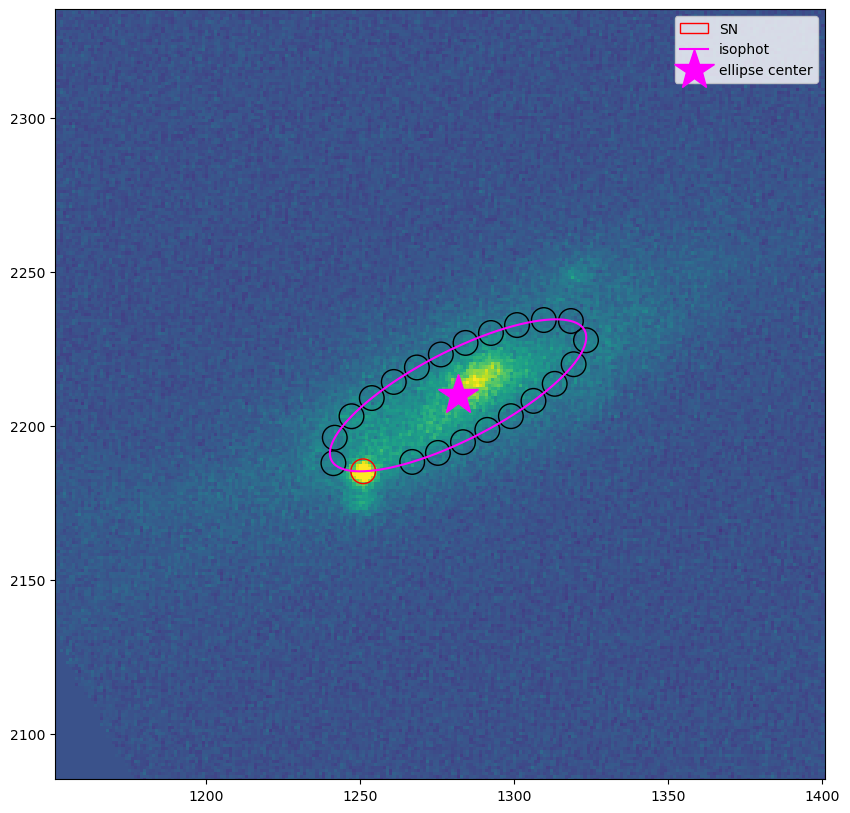

<Figure size 640x480 with 0 Axes>

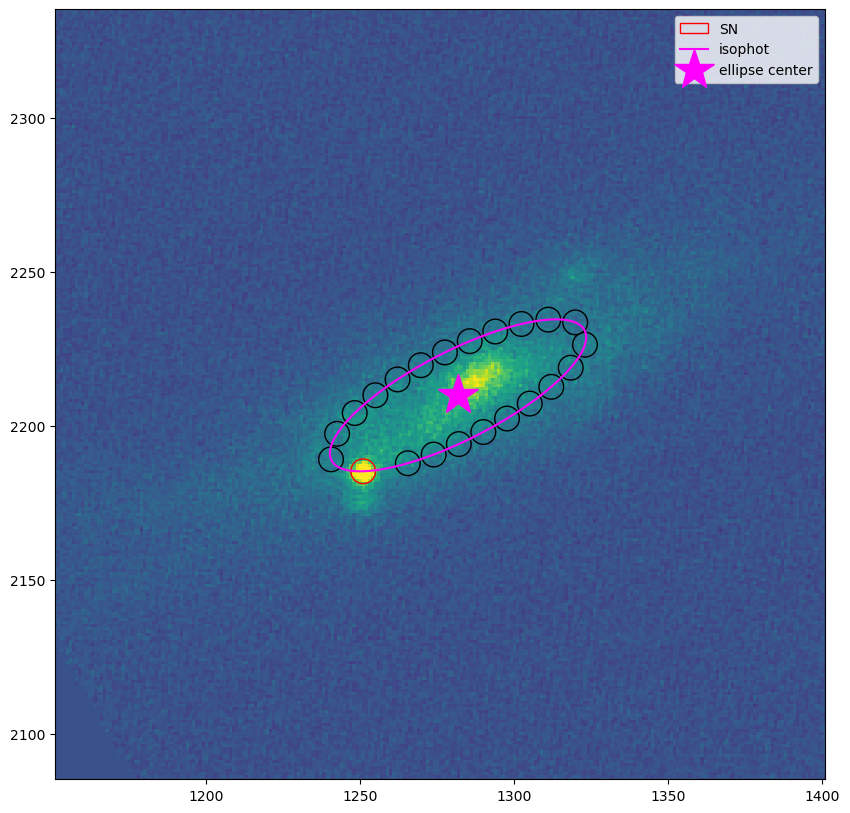

<Figure size 640x480 with 0 Axes>

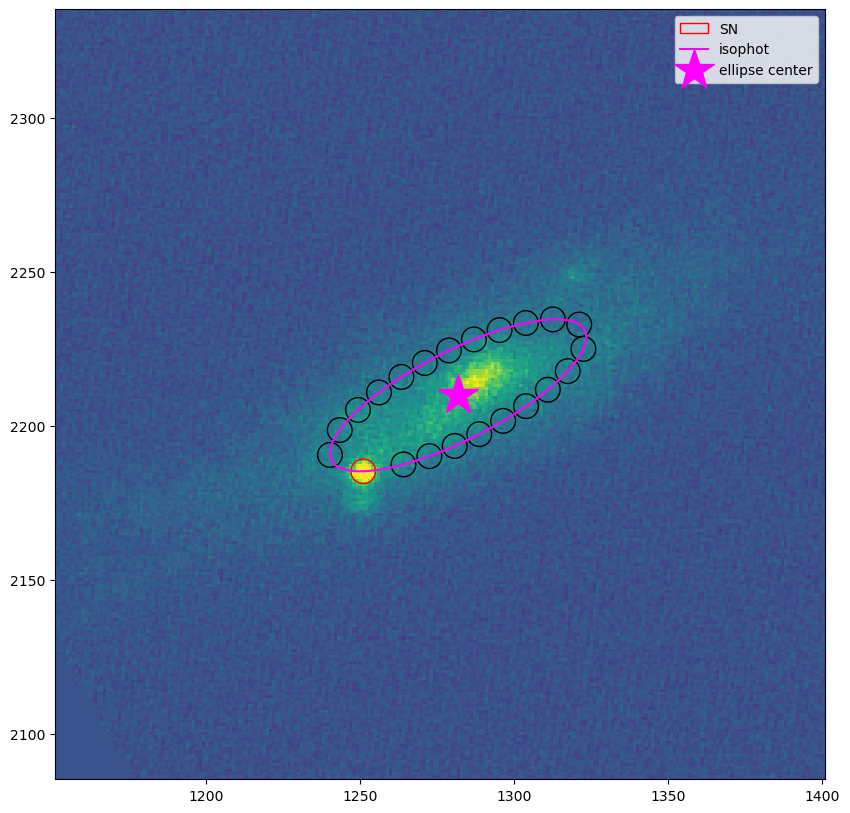

<Figure size 640x480 with 0 Axes>

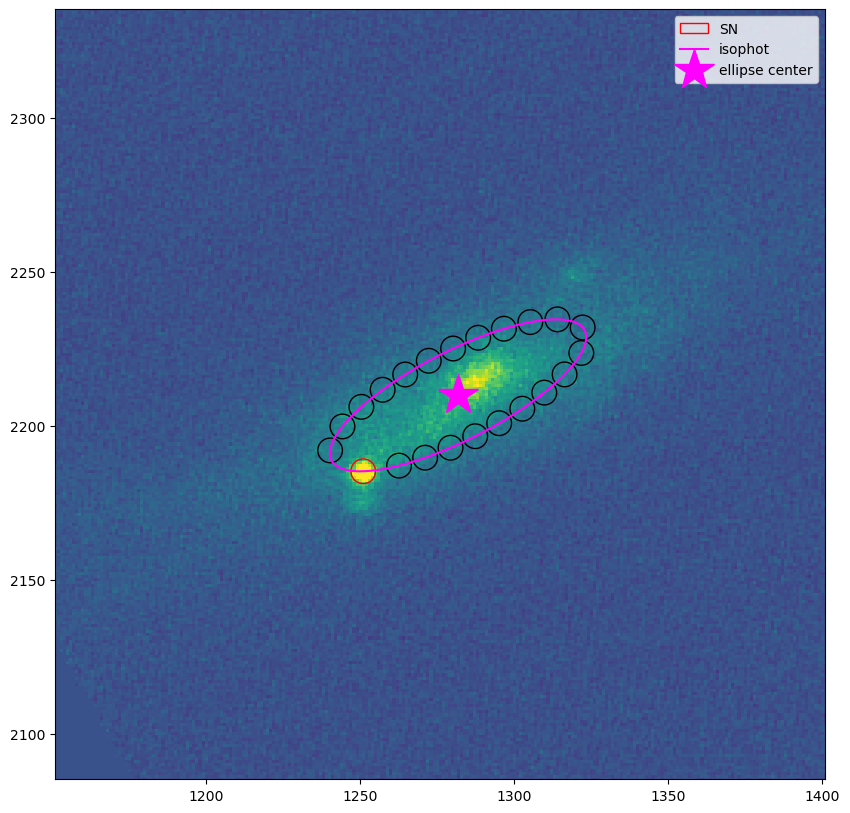

<Figure size 640x480 with 0 Axes>

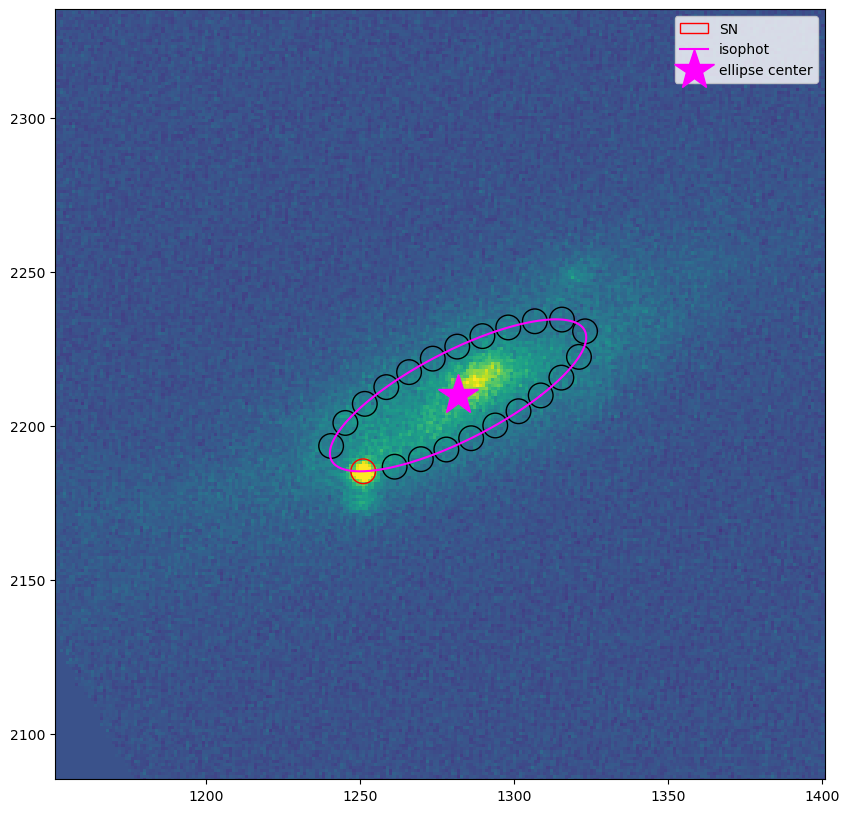

<Figure size 640x480 with 0 Axes>

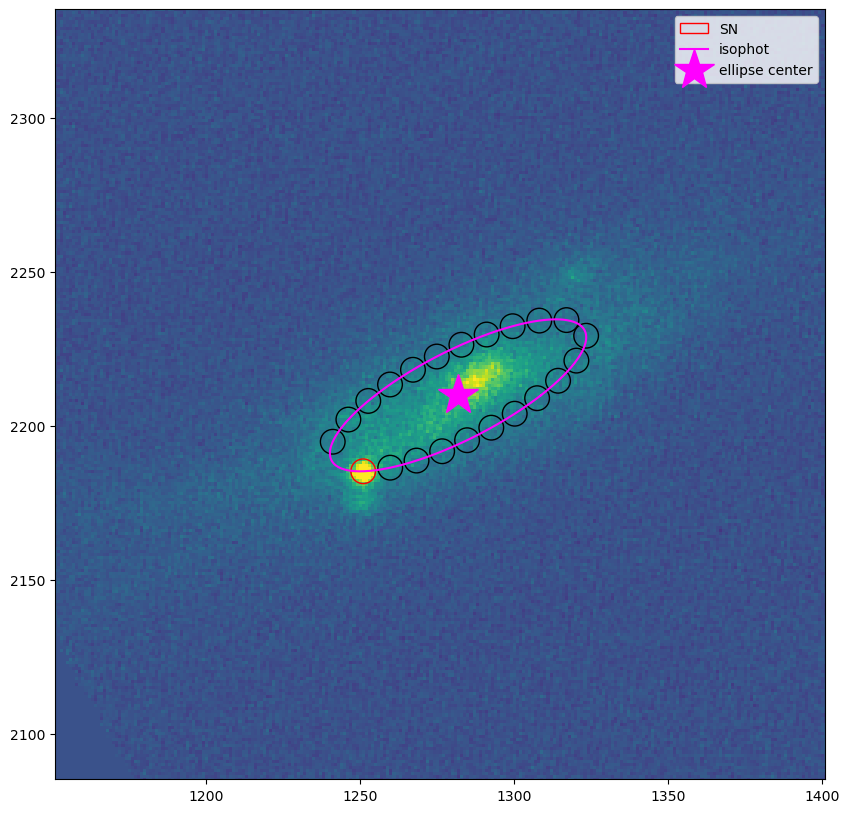

In [104]:
#determines steps by which to shift apertures by
n_step = 6
step = (space)/n_step
steps=np.arange(step, (space)+step, step)
arc_init = arc_sn+steps

j = 0
#loops through and shifts the apertures
for arc in arc_init:
    figure()
    arc_bkg_ap_step = arc + np.arange(num) * space
    amp_bkg_ap_step = optimize.root(lambda x: (a_opt*special.ellipeinc(x, e**2) - arc_bkg_ap_step), angles_0, tol=1e-10).x 
    x_bkg_ap_step = a_opt * np.sin(amp_bkg_ap_step)
    y_bkg_ap_step = b_opt * np.cos(amp_bkg_ap_step)
    
    #cuts out the aperture where the sn is located and the aperture next to it
    x_bkg_ap_step_cut = x_bkg_ap_step[1:-1]
    y_bkg_ap_step_cut = y_bkg_ap_step[1:-1]
    
    #translates the aperture coordinates to correct orientation
    x_bkg_step_final = x_bkg_ap_step_cut * np.cos(phi) -  y_bkg_ap_step_cut * np.sin(phi) + u
    y_bkg_step_final = x_bkg_ap_step_cut * np.sin(phi) +  y_bkg_ap_step_cut * np.cos(phi) + v

    
    #x_r_step, y_r_step = wi.all_pix2world(x_bkg_ap_step, y_bkg_ap_step+r_ap, 1)
    #r_world_step = np.array([x_r_step, y_r_step])-np.array([ra, dec])
    #r_world_step_arcsec = abs((r_world_step*units.deg).to(units.arcsec).value)[1] #radius in arseconds

    #converts pixels to ra and dec
    ra_bkg_step, dec_bkg_step = wi.all_pix2world(x_bkg_step_final, y_bkg_step_final, 1) #aperture coords in degree ra/dec as seperate arrays
    #ra_bkg, dec_bkg = (ra_bkg*units.deg).to(units.hourangle).value, (dec_bkg*units.deg).to(units.hourangle).value
    coord_list_step = []
    for i in range(len(ra_bkg_step)):
        coord_list_step.append(SkyCoord(ra=ra_bkg_step[i]*units.degree, dec=dec_bkg_step[i]*units.degree).to_string('hmsdms'))
    #saves the apertures
    direct = r'bkg_app_iter/bkg_app_{0:}.txt'.format(j)
    with open (direct, 'w') as output_file:
        output_text = "\n".join(str(x) for x in coord_list_step)
        output_file.write(output_text)
    
    j += 1

    #plot(x_ell_new, y_ell_new)
    #scatter(x_bkg_ap_step_cut, y_bkg_ap_step_cut)
    #scatter(x_new, y_new)
    #gca().add_patch(Circle((x_new, y_new), radius=r_ap, fill=False, color='g'))
    #for i in range(len(x_bkg_ap_step_cut)):
    #    gca().add_patch(Circle((x_bkg_ap_step_cut[i], y_bkg_ap_step_cut[i]), radius=r_ap, fill=False, color='r'))
    #axis('scaled')
    #show()
    
    figure(figsize=(10, 10))
    imshow(data, cmap='viridis', vmin=100, vmax=500)
    xlim(x-100, x+150)
    ylim(y-100, y+150)
    gca().add_patch(Circle((x, y), r_ap, color='r', fill=False, label='SN'))

    plot( x_ell+u, y_ell+v, color='magenta', label='isophot' )
    plot(u,v, '*', markersize=30, color='magenta', label='ellipse center')
    for i in range(len(x_bkg_step_final)):
        gca().add_patch(Circle((x_bkg_step_final[i], y_bkg_step_final[i]), radius=r_ap, fill=False, color='black'))

    legend(loc='upper right', fontsize=10)


    show()